## 3.1线性回归

### 正态分布与平方损失

In [1]:
import torch
import numpy as np

In [2]:
%matplotlib inline


In [9]:
import math 
from d2l import torch as d2l

In [13]:
import random

In [4]:
def normal(x,mu,sigma):
    p=1/math.sqrt(2*math.pi*sigma**2)
    return p*np.exp(-0.5/sigma**2*(x-mu)**2)

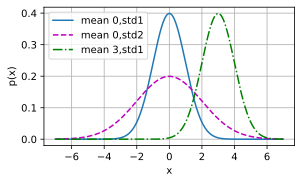

In [10]:
x=np.arange(-7,7,0.01)

params=[(0,1),(0,2),(3,1)]
d2l.plot(x,[normal(x,mu,sigma) for mu,sigma in params],xlabel='x',
         ylabel='p(x)',figsize=(4.5,2.5),
         legend=[f'mean {mu},std{sigma}' for mu,sigma in params],)

为什么用平方损失:<br>
- 假设噪声服从正态分布,有$y=\boldsymbol w^T \boldsymbol x +b+\epsilon$,其中,$\epsilon \sim N(0,\sigma^2)$.
- 则对于给定的$\boldsymbol x$我们可以得到y的似然:$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$
- 最小化负对数似然,可得$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$
- 假设标准差$\sigma$是某个固定的常数,可以发现需要优化的部分就和均方误差差了一个分母常数.

## 3.2线性回归的从0开始实现

### **3.2.1 generate**

In [12]:
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=d2l.synthetic_data(true_w,true_b,1000)

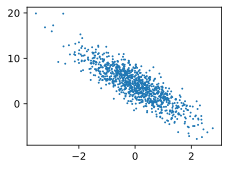

In [15]:
#view
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1);

### **3.2.2 读取数据**

随机梯度下降,则需要一个函数实现对样本抽样.

In [17]:
def data_iter(batch_size,featrues,labels):
    '''
    batch_size: size of son data
    features: X
    labels:y
    '''
    total=len(features)
    number=list(range(total))
    random.shuffle(number)

    for i in range(0,total,batch_size):
        batch_indices=torch.tensor(
            number[i:min(i+batch_size,total)])  # 从打乱的序号选出长度为batch_size的
        yield features[batch_indices],labels[batch_indices] #根据一个序列来索引; 使用生成器,省内存

In [18]:
batch_size=10
groups=data_iter(batch_size,features,labels)

In [19]:
for feature,label in groups:
    print(f'{feature}\n{label}')
    break

tensor([[-2.2953, -0.1015],
        [ 1.2387,  0.4202],
        [-0.4954, -0.2205],
        [-0.5700,  1.3248],
        [ 0.0218,  0.1384],
        [ 0.1885, -0.5553],
        [-1.3757, -1.5840],
        [ 0.4818,  1.0214],
        [ 0.2390, -0.2600],
        [ 0.7104,  0.7088]])
tensor([[-0.0443],
        [ 5.2649],
        [ 3.9534],
        [-1.4451],
        [ 3.7587],
        [ 6.4607],
        [ 6.8303],
        [ 1.6860],
        [ 5.5672],
        [ 3.2232]])


当然,这只是教学.上面这个例子要求将所有数据加载到内存,并执行大量随机内存访问.<br>

深度学习框架中实现的内置迭代器则是处理文件中的数据/数据流

### **3.2.3. 初始化模型参数**

In [20]:
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)
#利用自动微分

### **3.2.4 定义模型**

In [26]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b #broadcast, Vector and a number(b)

### **3.2.5 定义损失函数**

In [22]:
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2  #look out the shape    in case of bug

### **3.2.6 定义优化算法**
就是对w或者b做随机梯度下降的算法

In [143]:
def sgd(params,lr,batch_size):
    '''
    params: w and b
    lr: learning rate
    batch_size: size of son
    '''
    with torch.no_grad():
        for param in params:
            param-=lr*param.grad/batch_size  # /batch_size 实现归一化,防止因随机挑选的数量的不同产生干扰
            #可变对象的`-=`实现了就地修改
            param.grad.zero_()
            

`with torch.no_grad()` 是 PyTorch 中的一个上下文管理器，用于禁用梯度计算。在这个上下文块中执行的操作不会被自动微分系统追踪，也不会计算梯度。

主要作用：
1. 节省内存和计算资源
梯度计算需要保存中间结果，禁用梯度计算可以：
- 减少显存占用
- 提高计算速度

2. 避免不必要的梯度计算
在以下场景中不需要梯度：
- 模型推理/预测：只需要前向传播结果
- 参数更新：手动更新参数时（如你的代码示例）
- 评估阶段：测试或验证时

### **3.2.7 训练**

在每次迭代中,我们
- 读取小批量训练样本,
- 并通过我们的模型获得一组预测.
- 计算完损失后,我们开始反向传播,存储每个参数的梯度.
- 最后,我们调研优化算法来更新模型参数.

对于设置超参数,很棘手,需要反复实验,暂时忽略,见11章

In [109]:
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

In [94]:
w=torch.zeros((2,1),requires_grad=True) 
w
#在创建的时候要注意不能多别的步骤,
    ##eg:w=torch.zeros(2,requires_grad=True).reshape(2,1) ,这里reshape会影响梯度.
#应当检查,正确情况下后面是 requires_grad=True

tensor([[0.],
        [0.]], requires_grad=True)

In [118]:
lr=0.03
num_epochs=3  #轮数
net=linreg
loss=squared_loss

In [119]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y) #l的形状是(batch_size,1)而不是标量
        l.sum().backward() #求和,然后计算关于[w,b]的梯度
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
        print(f'epoch {epoch+1},loss {float(train_l.mean()):f}')

epoch 1,loss 0.000050
epoch 2,loss 0.000050
epoch 3,loss 0.000050


In [120]:
w,b

(tensor([[ 2.0006],
         [-3.4004]], requires_grad=True),
 tensor([4.1999], requires_grad=True))

In [121]:
true_w

tensor([ 2.0000, -3.4000])

In [122]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0006,  0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0001], grad_fn=<RsubBackward1>)


## 3.3线性回归的简洁实现

### 生成数据集,这里借用了d2l中写好的函数(前面也有)

In [155]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 读取数据集

In [412]:
def load_array(data_arrays,batch_size,is_train=True):
    '''
    data_arrays: X
    batch_size:一批/一群
    is_train: 是否希望在每个迭代周期打乱数据
    '''
    dataset=data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

batch_size=10
data_iter=load_array((features,labels),batch_size)

In [413]:
data_iter

In [414]:
#但是data_iter不是序列或迭代器

In [415]:
#list(data_iter)[0]  --->it's ok
next(iter(data_iter))

[tensor([[ 0.8957, -0.1233],
         [ 0.5893, -3.2716],
         [-0.4032, -2.5530],
         [ 0.0241, -0.1741],
         [-0.3435, -1.1294],
         [ 0.0969, -0.0886],
         [-1.1318, -0.1282],
         [ 1.1161, -0.8632],
         [ 0.1224, -0.4380],
         [ 0.5822, -1.0464]]),
 tensor([[ 6.4029],
         [16.5024],
         [12.0880],
         [ 4.8391],
         [ 7.3391],
         [ 4.6943],
         [ 2.3807],
         [ 9.3820],
         [ 5.9290],
         [ 8.9152]])]

### 定义模型


对于标准深度学习模型，我们可以使用框架的预定义好的层。

我们首先定义一个**模型变量net**，它是一个**Sequential类的实例**.
- Sequential类将多个层串联在一起。
- 当给定输入数据时，Sequential实例将数据传入到第一层，然后将第一层的输出作为第二层的输入，
- 以此类推。

*在下面的例子中，我们的模型只包含一个层，因此实际上不需要Sequential。但是由于以后几乎所有的模型都是多层的，在这里使用Sequential会让你熟悉“标准的流水线”。*

在PyTorch中，全连接层在Linear类中定义。

值得注意的是，我们将两个参数传递到nn.Linear中。
- 第一个指定输入特征形状，即2，
- 第二个指定输出特征形状，输出特征形状为单个标量，因此为1。

In [416]:
from torch import nn #neural network

net=nn.Sequential(nn.Linear(2,1))

### 初始化模型参数

In [417]:
# net 就是"模型",储存着结构的相关信息
#实际上在上一步给出输入输出后此时net已经有参数了,不过我们可以也手动设置
net[0].weight.data.normal_(0,0.01)

tensor([[0.0063, 0.0106]])

In [418]:
net[0].weight.data

tensor([[0.0063, 0.0106]])

In [419]:
net[0].bias.data.fill_(0)

tensor([0.])

事实上,这里直接赋值也行
```python
net[0].weight.data=torch.tensor([[0.,0.]])
```

### 定义损失函数

In [420]:
loss = nn.MSELoss(reduction='mean')  
#采用mean时受前面batch_size的影响小,而且误差可以迅速降下来.
#而采用sum时受batch_size的影响很大,会飚到inf.  此时要么减小学习率,要么减小batch_size(每一次随机抽取的样本)

### 定义优化算法
小批量随机梯度下降算法是一种优化神经网络的标准工具,PyTorch在optim模块实现了该算法的许多变种.

实例化一个实例时,需要指定<mark>优化的参数</mark> *(通过net.parameters()从模型中获得)* 以及优化算法所需的<mark>超参数</mark>字典

In [421]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 训练
训练的过程和前面从0开始类似

In [422]:
num_epochs = 9
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)#通过调用net(X)生成预测并计算损失l（前向传播）
        #trainer.zero_grad()
        l.backward() #通过进行反向传播来计算梯度。
        trainer.step() #通过调用优化器来更新模型参数
        trainer.zero_grad() #将梯度清0,否则反向传播计算梯度默认叠加

    #为了更好的衡量训练效果，我们计算每个迭代周期后的损失，并打印它来监控训练过程。
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')


epoch 1, loss 0.000168
epoch 2, loss 0.000102
epoch 3, loss 0.000102
epoch 4, loss 0.000103
epoch 5, loss 0.000104
epoch 6, loss 0.000103
epoch 7, loss 0.000104
epoch 8, loss 0.000102
epoch 9, loss 0.000102


我们比较生成数据集的真实参数和通过有限数据训练获得的模型参数

In [423]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)


w的估计误差： tensor([-0.0005,  0.0002])
b的估计误差： tensor([-0.0004])


- 我们可以使用PyTorch的高级API更简洁地实现模型。
- 在PyTorch中，data模块提供了数据处理工具，nn模块定义了大量的神经网络层和常见损失函数。
- 我们可以通过`_`结尾的方法将参数替换，从而初始化参数。



In [427]:
# net 就是"模型",储存着结构的相关信息
#实际上在上一步给出输入输出后此时net已经有参数了,不过我们可以也手动设置
net[0].weight.data.normal_(0,0.01)

net[0].bias.data.fill_(0)

loss = nn.MSELoss(reduction='sum')  
#采用mean时受前面batch_size的影响小,
#而采用sum时受batch_size的影响很大. 此时要么减小学习率,要么减小batch_size(每一次随机抽取的样本)


trainer = torch.optim.SGD(net.parameters(), lr=0.01)

num_epochs = 9
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)#通过调用net(X)生成预测并计算损失l（前向传播）
        #trainer.zero_grad()
        l.backward() #通过进行反向传播来计算梯度。
        trainer.step() #通过调用优化器来更新模型参数
        trainer.zero_grad() #将梯度清0,否则反向传播计算梯度默认叠加

    #为了更好的衡量训练效果，我们计算每个迭代周期后的损失，并打印它来监控训练过程。
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)


epoch 1, loss 0.104310
epoch 2, loss 0.103143
epoch 3, loss 0.105850
epoch 4, loss 0.107093
epoch 5, loss 0.120394
epoch 6, loss 0.104066
epoch 7, loss 0.105725
epoch 8, loss 0.106213
epoch 9, loss 0.112098
w的估计误差： tensor([-0.0006, -0.0008])
b的估计误差： tensor([0.0027])
